### Solving Poisson Equation on S^2: $\Delta u = f$


In [1]:
import my_ducc0_wrapper
from my_ducc0_wrapper import *

In [2]:
import torch

N = 200

from Basis import SPHBasis
from Problem import Problem_Sphere_Poisson
from Model import Model
from Net import Sphere_Net, SPH_Sphere_Net
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import pi
from spherical_harmonics import *
from torch.distributions.uniform import Uniform
from numpy import arccos
import numpy as np

import pyshtools
from pyshtools.shio import shread
from pyshtools.expand import MakeGridDH
# from pyshtools.expand import SHExpandDH
from pyshtools.spectralanalysis import spectrum

torch.manual_seed(0)
maxiter = 1000
problem = Problem_Sphere_Poisson()

In [3]:
N = 13
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)

## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

azimuth, polar = torch.meshgrid(azimuth, polar)
location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
location.shape

torch.Size([338, 2])

iteration 0: loss = 83.19385528564453


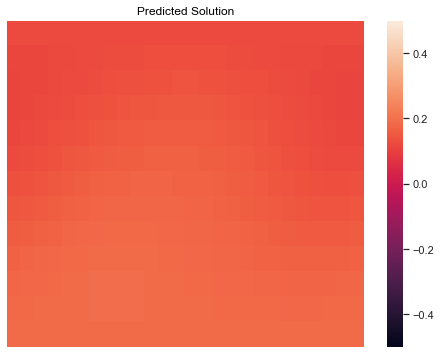

-----------------------------
[[[ 1.58026084e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.96936466e-02 -9.44437273e-03  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-6.34342607e-04 -3.81574035e-03 -9.74196533e-04  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-3.54894401e-05 -9.98060423e-05 -6.00948479e-05 -1.49188534e-04
    0.00000000e+00  0.00000000e+00]
  [-2.46499723e-04 -6.98107906e-05  1.42360033e-04 -4.10022294e-05
   -2.43169347e-06  0.00000000e+00]
  [ 1.39178243e-04  2.98090472e-05  1.80500974e-05  7.39859888e-06
    6.83959443e-05 -3.10934911e-06]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  6.09919429e-03  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -8.56512284e-04  8.24988005e-04  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -5.38710970e-04  1.023

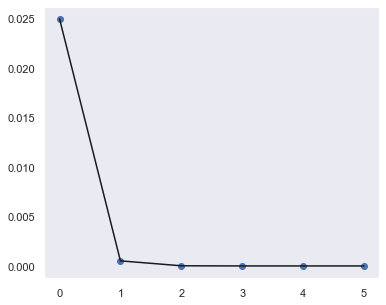

iteration 10: loss = 82.29561614990234
iteration 20: loss = 79.3809585571289
iteration 30: loss = 67.24846649169922
iteration 40: loss = 58.962257385253906
iteration 50: loss = 55.636451721191406
iteration 60: loss = 51.20600128173828
iteration 70: loss = 43.361061096191406
iteration 80: loss = 36.99370193481445
iteration 90: loss = 27.82691192626953
iteration 100: loss = 15.778602600097656


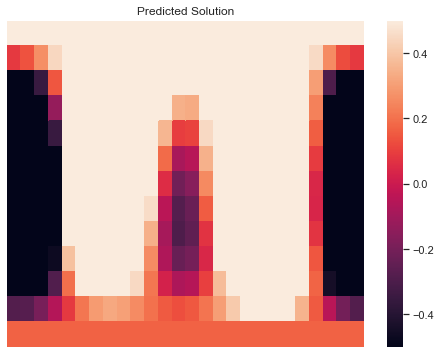

-----------------------------
[[[ 4.31622386e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.65518045e-01 -6.99992418e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-6.04102015e-03 -1.17718212e-01 -1.01435208e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.20768568e-03  6.01509912e-03 -7.97996372e-02  2.63502598e-02
    0.00000000e+00  0.00000000e+00]
  [ 6.93924911e-03 -3.41275074e-02 -9.76900607e-02  1.87353101e-02
    2.64419857e-02  0.00000000e+00]
  [-4.14041057e-03  1.93607453e-02 -6.13240004e-02  6.99264201e-05
   -9.84464120e-03  3.81687209e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.21119462e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.58799586e-02  2.35204279e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -5.70519874e-03  2.644

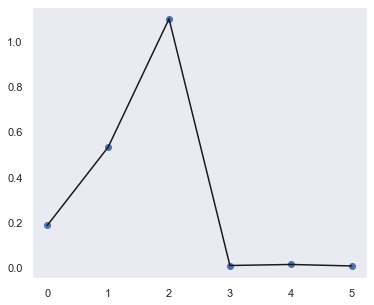

iteration 110: loss = 7.000059127807617
iteration 120: loss = 5.166647434234619
iteration 130: loss = 4.187839984893799
iteration 140: loss = 3.6281368732452393
iteration 150: loss = 3.2465097904205322
iteration 160: loss = 2.96132755279541
iteration 170: loss = 2.7547545433044434
iteration 180: loss = 2.5815939903259277
iteration 190: loss = 2.4280879497528076
iteration 200: loss = 2.2879254817962646


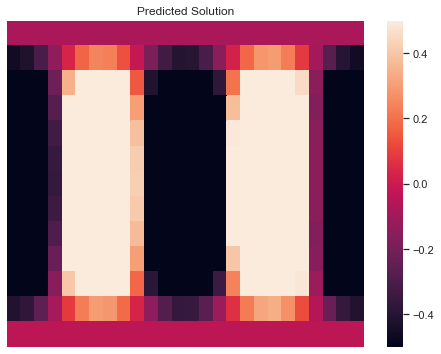

-----------------------------
[[[-1.12685487e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.71329100e-02 -1.96478620e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.69535372e-02 -2.05449425e-02 -1.38469088e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-5.04867965e-03  1.04613965e-02 -1.24817304e-01  9.03116018e-02
    0.00000000e+00  0.00000000e+00]
  [ 7.53044197e-03 -8.01355951e-03 -1.41048789e-01  9.09350254e-03
    3.48061658e-02  0.00000000e+00]
  [ 3.28542828e-03  1.06012365e-02 -8.62958953e-02  1.89112648e-02
    8.64435628e-04  1.57746971e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -2.99870856e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -4.95136576e-03  3.34291220e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.29434851e-03  2.527

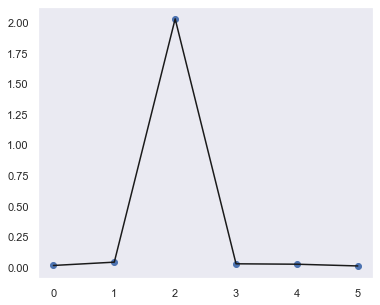

iteration 210: loss = 2.1568922996520996
iteration 220: loss = 2.0333449840545654
iteration 230: loss = 1.9137794971466064
iteration 240: loss = 1.795856237411499
iteration 250: loss = 1.6780258417129517
iteration 260: loss = 1.5610054731369019
iteration 270: loss = 1.4463738203048706
iteration 280: loss = 1.3371801376342773
iteration 290: loss = 1.2344731092453003
iteration 300: loss = 1.1385974884033203


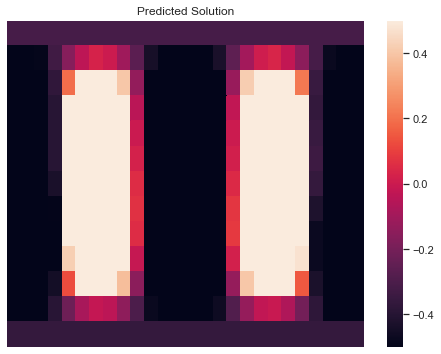

-----------------------------
[[[-4.09143358e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 9.37121268e-03 -9.21783075e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.36726590e-02  2.02157516e-02 -1.35799682e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-4.99348808e-03 -2.78350478e-03 -1.16864212e-01  9.21752676e-02
    0.00000000e+00  0.00000000e+00]
  [ 9.42356419e-03 -2.14899871e-02 -1.63157046e-01  2.60715769e-03
    3.15423980e-02  0.00000000e+00]
  [ 6.69632107e-03  1.26518533e-02 -9.62897688e-02  1.48610547e-02
    2.48783780e-03  1.58798844e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.18238013e-03  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -7.86921068e-04  3.28361332e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.05546240e-03  2.577

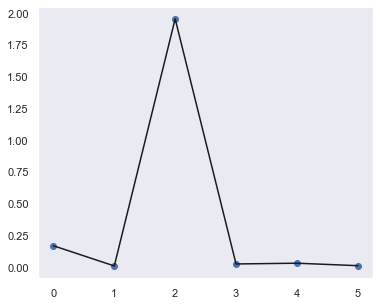

iteration 310: loss = 1.0493477582931519
iteration 320: loss = 0.9660022854804993
iteration 330: loss = 0.8866763114929199
iteration 340: loss = 0.8099663853645325
iteration 350: loss = 0.7343647480010986
iteration 360: loss = 0.6594371199607849
iteration 370: loss = 0.5870129466056824
iteration 380: loss = 0.5196210145950317
iteration 390: loss = 0.4603857100009918
iteration 400: loss = 0.41256338357925415


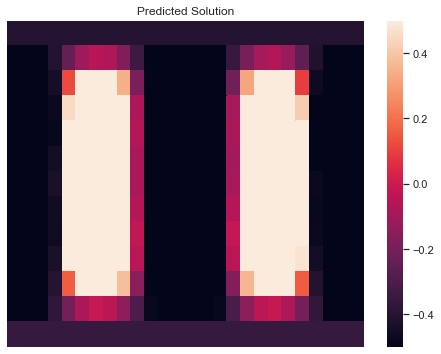

-----------------------------
[[[-4.65985298e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.77345050e-02 -6.85248151e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.61148492e-02 -3.38437827e-03 -1.33178866e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 6.68758340e-03 -1.46695375e-02 -1.07797280e-01  8.66031051e-02
    0.00000000e+00  0.00000000e+00]
  [ 3.18617653e-03 -1.45047205e-02 -1.80889338e-01  5.10814972e-03
    2.95702498e-02  0.00000000e+00]
  [ 2.21477170e-03  1.62025690e-02 -1.05795056e-01  1.72338784e-02
    1.02042349e-03  1.67407934e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.76566634e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  4.95022023e-03  3.32031846e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.44663982e-03  2.786

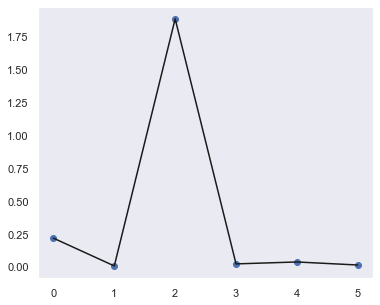

iteration 410: loss = 0.3747595250606537
iteration 420: loss = 0.34606751799583435
iteration 430: loss = 0.32289329171180725
iteration 440: loss = 0.3031586706638336
iteration 450: loss = 0.2856009602546692
iteration 460: loss = 0.2694196105003357
iteration 470: loss = 0.25408416986465454
iteration 480: loss = 0.23921777307987213
iteration 490: loss = 0.22470439970493317
iteration 500: loss = 0.21054762601852417


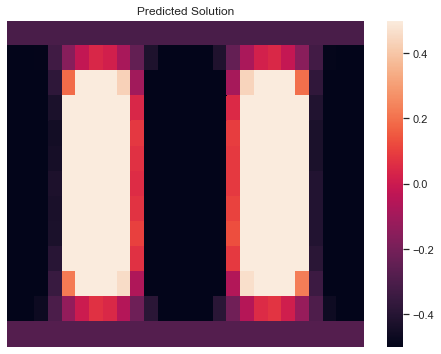

-----------------------------
[[[-3.70777130e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.06289347e-02 -1.13463044e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.12520787e-02 -8.32520239e-03 -1.32223070e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.36491705e-03 -5.97813446e-03 -1.05314374e-01  8.73635635e-02
    0.00000000e+00  0.00000000e+00]
  [ 3.52042029e-03 -1.27654448e-02 -1.86119676e-01  6.18774397e-03
    3.02243307e-02  0.00000000e+00]
  [ 1.12900278e-03  1.59772467e-02 -1.08540222e-01  1.94778498e-02
    1.07767445e-03  1.64971501e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  5.60433744e-03  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  9.29616333e-04  3.27093750e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.38673948e-03  2.527

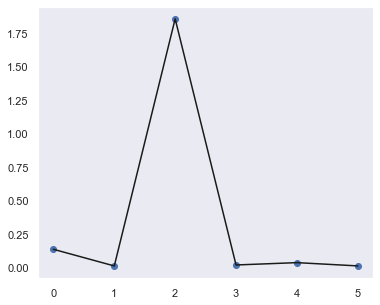

iteration 510: loss = 0.19662798941135406
iteration 520: loss = 0.18300381302833557
iteration 530: loss = 0.16972115635871887
iteration 540: loss = 0.1567775160074234
iteration 550: loss = 0.14428825676441193
iteration 560: loss = 0.1323707103729248
iteration 570: loss = 0.12106835842132568
iteration 580: loss = 0.11054863035678864
iteration 590: loss = 0.10084977000951767
iteration 600: loss = 0.09205932170152664


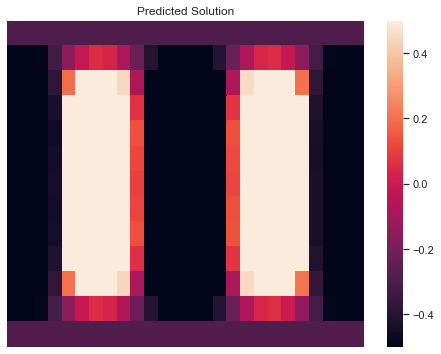

-----------------------------
[[[-3.67641062e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-9.66774486e-03 -1.33955345e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.59676185e-02 -1.38437720e-02 -1.31645143e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.66377154e-04  7.76347370e-05 -1.03437051e-01  8.62734169e-02
    0.00000000e+00  0.00000000e+00]
  [ 6.52045850e-03 -1.04147289e-02 -1.89376682e-01  5.35953371e-03
    3.07349060e-02  0.00000000e+00]
  [ 2.17435323e-03  1.35011254e-02 -1.10634185e-01  2.08170023e-02
    1.57814182e-03  1.61000360e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.12069957e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.41304836e-03  3.24125946e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.67030404e-04  2.465

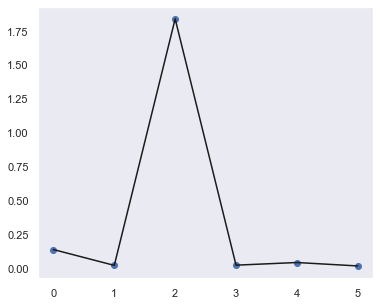

iteration 610: loss = 0.08414488285779953
iteration 620: loss = 0.07707781344652176
iteration 630: loss = 0.07078130543231964
iteration 640: loss = 0.06515640020370483
iteration 650: loss = 0.06010361388325691
iteration 660: loss = 0.05556275323033333
iteration 670: loss = 0.0514657236635685
iteration 680: loss = 0.04775801673531532
iteration 690: loss = 0.0443764328956604
iteration 700: loss = 0.041306570172309875


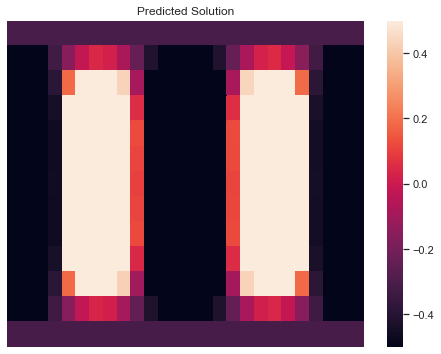

-----------------------------
[[[-3.79920453e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-6.01362716e-03 -1.36368304e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.42141243e-02 -1.43164136e-02 -1.31463683e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.09838939e-03  2.11235508e-03 -1.03018440e-01  8.58191177e-02
    0.00000000e+00  0.00000000e+00]
  [ 7.84755126e-03 -9.07847844e-03 -1.91135645e-01  5.40259900e-03
    3.08684390e-02  0.00000000e+00]
  [ 3.39569547e-03  1.23206358e-02 -1.11764222e-01  2.14241613e-02
    1.64951861e-03  1.58219822e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.38957007e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.34368532e-03  3.23615640e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -1.66788275e-04  2.518

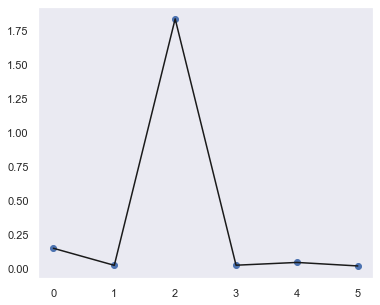

iteration 710: loss = 0.03852247819304466
iteration 720: loss = 0.03598282113671303
iteration 730: loss = 0.03368491679430008
iteration 740: loss = 0.031570326536893845
iteration 750: loss = 0.029641296714544296
iteration 760: loss = 0.027888042852282524
iteration 770: loss = 0.026287075132131577
iteration 780: loss = 0.024813475087285042
iteration 790: loss = 0.02347230352461338
iteration 800: loss = 0.022241920232772827


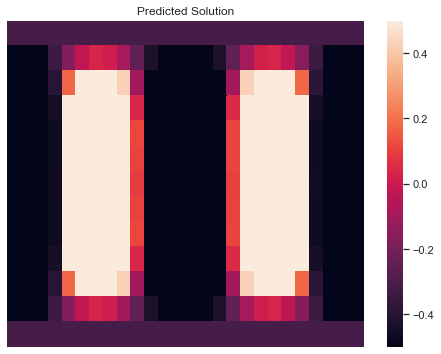

-----------------------------
[[[-3.85328650e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-7.25815166e-03 -1.35700777e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.35290527e-02 -1.34640168e-02 -1.31415176e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.17324083e-03  2.70732283e-03 -1.03021838e-01  8.56236219e-02
    0.00000000e+00  0.00000000e+00]
  [ 8.15943535e-03 -8.90866760e-03 -1.91859290e-01  5.48712863e-03
    3.09533589e-02  0.00000000e+00]
  [ 3.66216758e-03  1.19815022e-02 -1.12047523e-01  2.16787588e-02
    1.63478486e-03  1.56427696e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.48903402e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.24949066e-03  3.23861539e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -3.53893993e-04  2.540

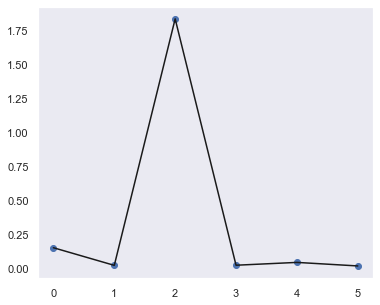

iteration 810: loss = 0.021108588203787804
iteration 820: loss = 0.020054670050740242
iteration 830: loss = 0.019089462235569954
iteration 840: loss = 0.01819729246199131
iteration 850: loss = 0.01736530289053917
iteration 860: loss = 0.016596084460616112
iteration 870: loss = 0.015884537249803543
iteration 880: loss = 0.01521748211234808
iteration 890: loss = 0.014593544416129589
iteration 900: loss = 0.014011656865477562


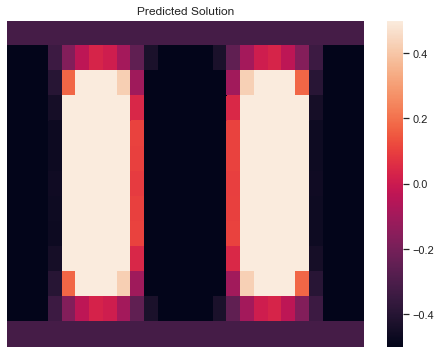

-----------------------------
[[[-3.89314443e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-7.41567649e-03 -1.34959430e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.32263822e-02 -1.29515789e-02 -1.31401241e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.14809128e-03  2.88960896e-03 -1.03033595e-01  8.55213925e-02
    0.00000000e+00  0.00000000e+00]
  [ 8.22221208e-03 -8.84745456e-03 -1.92247421e-01  5.50900074e-03
    3.09628081e-02  0.00000000e+00]
  [ 3.73677304e-03  1.18579008e-02 -1.12178534e-01  2.18050852e-02
    1.63326599e-03  1.55432839e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.55061716e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.28787907e-03  3.24006796e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -4.11057234e-04  2.542

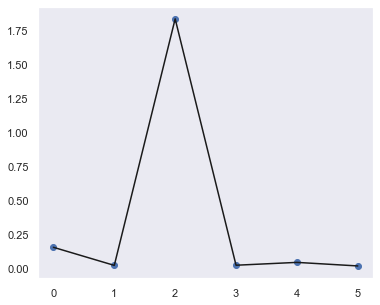

iteration 910: loss = 0.013469947502017021
iteration 920: loss = 0.012959936633706093
iteration 930: loss = 0.01247942354530096
iteration 940: loss = 0.012028198689222336
iteration 950: loss = 0.011600972153246403
iteration 960: loss = 0.01120107900351286
iteration 970: loss = 0.010820694267749786
iteration 980: loss = 0.0104635339230299
iteration 990: loss = 0.01012439839541912


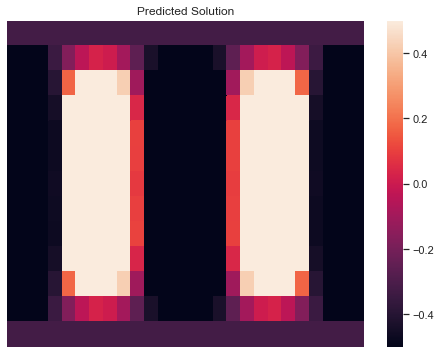

-----------------------------
[[[-3.91425759e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-7.55364727e-03 -1.34471178e-01  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.31572110e-02 -1.27516109e-02 -1.31392694e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-1.15250039e-03  2.94850115e-03 -1.03054471e-01  8.54439959e-02
    0.00000000e+00  0.00000000e+00]
  [ 8.22953321e-03 -8.81179236e-03 -1.92441911e-01  5.51837683e-03
    3.09621748e-02  0.00000000e+00]
  [ 3.76758352e-03  1.18056303e-02 -1.12246804e-01  2.18694694e-02
    1.63636392e-03  1.54833868e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.59954336e-02  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.36351760e-03  3.24028581e-01  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -4.36936854e-04  2.542

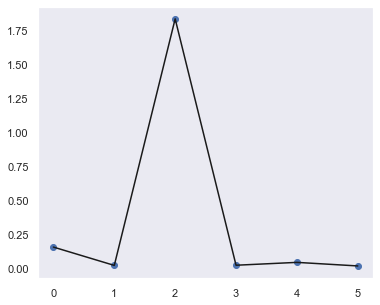

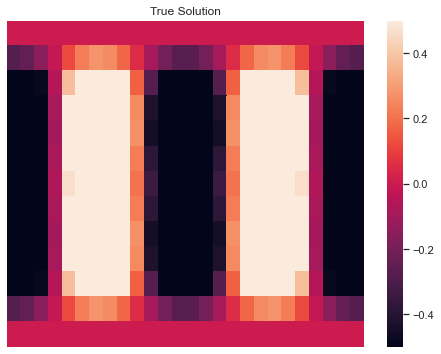

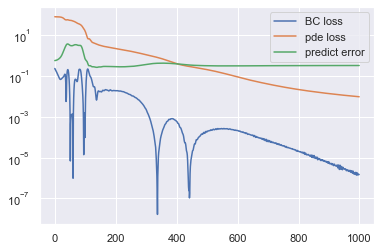

In [4]:

def construct_model(net):
    class Poisson1dModel(Model):
        def add_loss_history(self):
            self.loss_history.append([self.bc_loss, self.pde_loss, self.predict_error_value])

        def __init__(self):
            super().__init__(problem=problem, net=net, maxiter=maxiter)

        def inner_sample(self, N=N):
#             N = 25
#             cos_azimuth = torch.linspace(-0.9999, 0.9999, N, requires_grad=False)
#             azimuth = torch.arccos(cos_azimuth)
            azimuth = torch.linspace(0.0001, pi, N, requires_grad=False)
            polar = torch.linspace(0, 2*pi, 2*N, requires_grad=False)
            
            ## noise
#             dpolar = 2*pi/(2*N-1)
#             dazimuth = 2.0/(N-1)
#             polar_noise = torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
#             azimuth_noise = torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(azimuth.shape))            
#             azimuth, polar = azimuth + azimuth_noise, polar + polar_noise

            azimuth, polar = torch.meshgrid(azimuth, polar)
#             print('azimuth', azimuth.size())
#             print('polar', polar.size())
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
#             print('location', location.size())
            return location
#             x = torch.randn(num, 3)
#             x = x / (torch.norm(x, dim=1).reshape((-1, 1)))
        
#             polar = torch.atan(x[:, :1] / x[:, 1:2]) + math.pi / 2
#             polar[:num // 2, 0] = polar[:num // 2, 0] + math.pi
#             azimuth = torch.acos(x[:, 2:3])
            
#             ## noise
#             dpolar = 2 * pi/(num-1) 
#             polar_noise = polar + torch.distributions.Uniform(low = -dpolar/2, high = dpolar/2).sample(sample_shape=torch.Size(polar.shape))
            
#             dazimuth = pi/(num-1) 
#             azimuth_noise = azimuth + torch.distributions.Uniform(low = -dazimuth/2, high = dazimuth/2).sample(sample_shape=torch.Size(polar.shape))            
            
#             x = torch.cat([azimuth_noise, polar_noise], dim=1)
#             return x

        def bc_sample(self):
            return torch.tensor([[1., 1.]])

        def init_sample(self):
            pass

        def plot(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = net(location)
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Predicted Solution")
            plt.show()
            
            self.spherical_harmonic_transform(net)
        
        def spherical_harmonic_transform(self, net):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            function_grid = net(location)
            function_grid = function_grid.reshape((N, 2*N))
            
#             print(f'grid dims{function_grid}')
            
            ## if flag = True, compute adjoint instead
            coefficients = SHExpandDH(function_grid.detach().numpy(), sampling=2,flag = False)
            print("-----------------------------")
            print(coefficients)
            print("-----------------------------")
            nl = coefficients.shape[1]
            ls = np.arange(nl)[:10]
#             print(ls)

            power_per_l = spectrum(coefficients)[:10]
#             print(power_per_l)
            fig, ax = plt.subplots(1, 1, figsize=(len(ls), 5))
            ax.plot(ls, power_per_l, 'bo')
            ax.plot(ls, power_per_l, 'k-')
            plt.xticks(range(len(ls)))
            # ax.set_yscale('log')
            # ax.set_xscale('log')
            ax.grid()
            plt.show()
            
        
        def plot_true(self):
            azimuth = torch.linspace(0, math.pi, N, requires_grad=False)
            polar = torch.linspace(0, 2 * math.pi, 2*N, requires_grad=False)
            azimuth, polar = torch.meshgrid(azimuth, polar)
            location = torch.cat([azimuth.reshape(-1, 1), polar.reshape(-1, 1)], dim=1)
            value = true_solution(location[:, 0:1], location[:, 1:])
            
            value = value.reshape((N, 2*N))
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            sns.set()
            sns.heatmap(value.detach().numpy(), ax=ax, vmin=-0.5, vmax=0.5, cbar=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("True Solution")
            plt.show()
            
        def post_process(self, ax=None):
            if ax is None:
                plt.plot(self.loss_history)
                plt.yscale('log')
                plt.legend(('BC loss', 'pde loss', 'predict error'))
                plt.show()
            else:
                ax.plot(self.loss_history)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 100)
                ax.legend(('BC loss', 'pde loss', 'predict error'))

        def predict_error(self):
            coor = self.inner_sample()
            true = self.problem.ground_truth(coor)
            predict = self.net(coor)
            predict_error = self.pde_loss_f(true, predict)
            return predict_error

        def train(self, ax100=None):
            problem = self.problem
            net = self.net
            opt = self.opt
            maxiter = self.maxiter

            for iter in range(maxiter):
                net.zero_grad()

                coor_inner = self.inner_sample().detach().requires_grad_(True)
                infer_value_inner = net(coor_inner)
#                 print('coor_inner', coor_inner.size())
#                 print('infer_value_inner', infer_value_inner.size())
                truth_inner, predict_inner = problem.pde(coor_inner, infer_value_inner)
                self.pde_loss = self.pde_loss_f(predict_inner, truth_inner)

                bc_samples = self.bc_sample()
                if bc_samples is None:
                    self.bc_loss = torch.tensor(0.)
                else:
                    coor_bc = bc_samples.detach().requires_grad_(True)
                    infer_value_bc = net(coor_bc)
                    truth_bc, predict_bc = problem.bound_condition(coor_bc, infer_value_bc)
                    self.bc_loss = self.bc_loss_f(predict_bc, truth_bc)

                init_samples = self.init_sample()
                if init_samples is None:
                    self.init_loss = torch.tensor(0.)
                else:
                    coor_init = init_samples.detach().requires_grad_(True)
                    infer_value_init = net(coor_init)
                    truth_init, predict_init = problem.bound_condition(coor_init, infer_value_init)
                    self.init_loss = self.bc_loss_f(predict_init, truth_init)
                self.predict_error_value = self.predict_error()
                self.total_loss = self.pde_loss + self.bc_loss + self.init_loss
                self.add_loss_history()
                self.total_loss.backward()

                opt.step()
                opt.zero_grad()
                
                for i in range(len(self.loss_history)):
                    for j in range(3):
                        self.loss_history[i][j] = self.loss_history[i][j].detach().requires_grad_(False)
                        
                if iter % (maxiter // 100) == 0:
                    print("iteration {}: loss = {}".format(iter, self.total_loss))
                        
                if iter % int(maxiter / 10) == 0:
                    self.plot(net)
                
            self.plot(net)
            self.plot_true()
            self.post_process()

    return Poisson1dModel()

model = construct_model(Sphere_Net([3, 50, 50, 50, 16, 1]))
model.train()
